# Plant species classification

In [1]:
# Libraries needed
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import mahotas
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

In [2]:
def extract_features(path):
    image = cv2.imread(path)
    image = cv2.resize(image, (1600, 1600))
    image_b = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_lab = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)

    pixels = image_lab[:,:,1].flatten()
    pixels = np.float32(pixels)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    k = 2
    compactness, labels, centers = cv2.kmeans(pixels, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    centers = np.uint8(centers)
    segmented_image = centers[labels.flatten()]
    segmented_image = segmented_image.reshape(image_lab[:,:,1].shape)
    
    center_target = min(centers)
    binary_mask = np.where(segmented_image == center_target, 255, 0).astype(np.uint8)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    
    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_DILATE, kernel)

    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    leaf = np.zeros_like(image_lab[:,:,1])

    cv2.drawContours(leaf, [max(contours, key=cv2.contourArea)], -1, 255, 2)

    segmented_image = cv2.bitwise_and(image_b, image_b, mask=binary_mask)
    
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 3, 1)
    plt.imshow(image_b)
    plt.title("Base image")
    
    plt.subplot(2, 3, 2)
    plt.imshow(image_lab[:,:,1])
    plt.title("LAB image")

    plt.subplot(2, 3, 3)
    plt.imshow(segmented_image)
    plt.title("Segmented image")

    plt.subplot(2, 3, 4)
    plt.imshow(binary_mask, cmap="Greys_r")
    plt.title("Binary image")
    
    plt.subplot(2, 3, 5)
    plt.imshow(leaf, cmap="Greys_r")
    plt.title("leaf image")
    
    plt.show()
    
    contours, _ = cv2.findContours(leaf, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt,True)
    x,y,w,h = cv2.boundingRect(cnt)
    if w > h:
        aspect_ratio = float(h)/w
    else: 
        aspect_ratio = float(w)/h
    
    rectangularity = area / (w*h)
    
    circularity = (4 * np.pi * area) / ((perimeter)**2)
    equi_diameter = 2 * np.sqrt(area / np.pi)

    red_channel = segmented_image[:,:,0]
    green_channel = segmented_image[:,:,1]
    blue_channel = segmented_image[:,:,2]
    
    red_mean = np.mean(red_channel)
    green_mean = np.mean(green_channel)
    blue_mean = np.mean(blue_channel)
    
    red_std = np.std(red_channel)
    green_std = np.std(green_channel)
    blue_std = np.std(blue_channel)
    
    textures = mahotas.features.haralick(segmented_image)
    ht_mean = textures.mean(axis=0)
   
    contrast = ht_mean[1]
    correlation = ht_mean[2]
    inverse_diff_moments = ht_mean[4]
    entropy = ht_mean[8]
    
    return [area, perimeter, w, h, aspect_ratio, rectangularity, circularity, equi_diameter,
           red_mean, green_mean, blue_mean, red_std, green_std, blue_std, contrast,
           correlation, inverse_diff_moments, entropy]

In [3]:
def test_prediction(models, test_data):
    labels = ['Basil', 'Guava', 'Lemon', 'Mango']
    
    for model_name, model in models.items():
        predictions = model.predict(test_data)
        
        print(f"\n{model_name} Predictions:")
        for i, prediction in enumerate(predictions):
            print(f"Sample {i+1}: Predicted: {labels[prediction]}")

In [4]:
def evaluate_model(y_test, y_pred):
    conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
     
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    plt.show()
    
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f'Precision: {precision_score(y_test, y_pred, average="weighted")}')
    print(f'Recall: {recall_score(y_test, y_pred, average="weighted")}')
    print(f'F1-score: {f1_score(y_test, y_pred, average="weighted")}')

In [ ]:
def tuning_parameters(model, param_grid):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
    grid_search.fit(X_train_scaled, y_train)
    best_model = grid_search.best_estimator_
    return best_model

In [22]:
data = pd.read_csv("plant_features_kmeans_v1.csv", index_col=0)

In [23]:
data.shape

(4524, 20)

In [24]:
data.head()

,area,perimeter,physiological_length,physiological_width,aspect_ratio,rectangularity,circularity,diameter,mean_red,mean_green,mean_blue,stddev_red,stddev_green,stddev_blue,contrast,correlation,inverse_difference_moments,entropy,species,img_name
0,251830.5,2078.986051,727,504,0.693260,0.687295,0.732175,566.251314,10.930376,14.460003,4.103262,34.201665,44.712828,14.676957,439.822941,0.838624,0.910960,1.680934,Lemon,aug_180_0010_0097.JPG
1,274734.5,2549.471334,666,748,0.890374,0.551490,0.531157,591.441316,13.108776,16.972027,6.999141,38.236689,49.363227,20.740269,382.273339,0.888081,0.905130,1.712280,Lemon,aug_270_0010_0053.JPG
2,307681.5,2541.093697,530,890,0.595506,0.652282,0.598784,625.901153,11.604770,16.071092,3.818021,32.547509,44.373341,12.703678,512.388925,0.804973,0.891364,1.999970,Lemon,aug_90_0010_0067.JPG
3,243653.5,2044.074367,708,495,0.699153,0.695239,0.732806,556.982290,8.474915,11.537884,3.992784,26.924183,36.307896,13.890615,254.141807,0.858373,0.913536,1.598157,Lemon,aug_flip_0_0010_0091.JPG
4,214798.5,2131.505823,810,421,0.519753,0.629889,0.594112,522.962661,6.359837,9.133144,1.989084,21.906253,30.748566,8.921230,256.799268,0.793002,0.924629,1.425647,Lemon,aug_flip_1_0010_0132.JPG


In [25]:
data.describe()

,area,perimeter,physiological_length,physiological_width,aspect_ratio,rectangularity,circularity,diameter,mean_red,mean_green,mean_blue,stddev_red,stddev_green,stddev_blue,contrast,correlation,inverse_difference_moments,entropy
count,4.524000e+03,4524.000000,4524.000000,4524.000000,4524.000000,4524.000000,4524.000000,4524.000000,4524.000000,4524.000000,4524.000000,4524.000000,4524.000000,4524.000000,4524.000000,4524.000000,4524.000000,4524.000000
mean,3.800975e+05,2862.505694,818.844828,733.678824,0.713386,0.642218,0.593866,675.888286,12.352589,17.448106,8.651838,29.865826,41.480473,21.535226,284.452793,0.883017,0.865300,2.320428
std,1.749034e+05,930.222048,301.416673,262.030242,0.176060,0.084772,0.144272,164.730705,6.287602,8.549658,5.468531,8.895768,11.274929,8.495336,160.019998,0.048205,0.061824,0.962501
min,3.392700e+04,730.340180,197.000000,197.000000,0.311401,0.222636,0.054092,207.839356,1.594662,2.072027,1.019065,12.292976,17.122118,5.362522,28.591940,0.737310,0.608197,0.246775
25%,2.450612e+05,2227.205352,596.750000,546.000000,0.584044,0.598804,0.483720,558.589003,7.714367,11.090441,4.578081,23.029141,32.947843,14.651054,157.558314,0.847116,0.821857,1.598221
50%,3.654860e+05,2776.298277,764.000000,689.000000,0.733415,0.654600,0.602449,682.166477,11.195512,16.071892,7.535835,29.105787,40.433724,20.005440,257.243818,0.894110,0.871462,2.255575
75%,5.038345e+05,3464.817915,985.000000,865.000000,0.856952,0.700809,0.715378,800.938202,16.023965,22.350197,11.338601,35.743350,49.362581,27.157813,381.106449,0.918496,0.912843,2.993282
max,1.100323e+06,8512.629291,1600.000000,1600.000000,1.000000,0.801824,0.859778,1183.627794,50.882419,66.909698,41.731684,62.317875,81.827472,52.521205,1049.912568,0.966667,0.987962,5.839192


In [26]:
label_encoder = preprocessing.LabelEncoder()
data["species"] = label_encoder.fit_transform(data["species"])
label_encoder.classes_

array(['Basil', 'Gauva', 'Lemon', 'Mango'], dtype=object)

In [27]:
data["species"].value_counts()

species
1    1662
3    1020
2     954
0     888
Name: count, dtype: int64

In [28]:
X = data.drop(["species", "img_name", "stddev_blue", "stddev_green", "stddev_red", "mean_red", "mean_green", "mean_blue", "contrast"] ,axis=1)
y = data["species"]

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

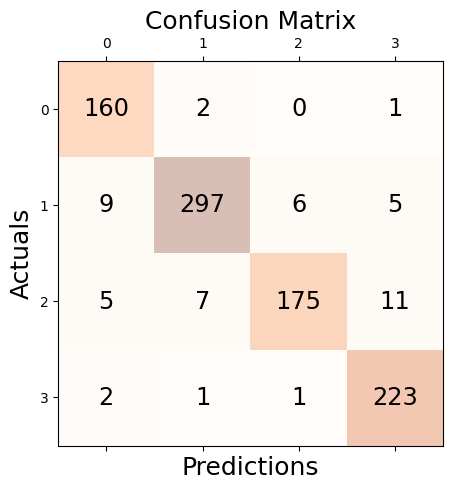

Accuracy: 0.9447513812154696
Precision: 0.9460348441997173
Recall: 0.9447513812154696
F1-score: 0.9445134082237177


In [31]:
svc = svm.SVC(kernel="rbf").fit(X_train_scaled, y_train)
y_pred_svc = svc.predict(X_test_scaled)
evaluate_model(y_test, y_pred_svc)

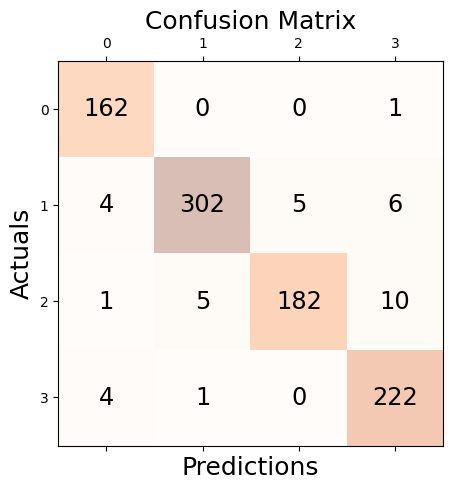

Accuracy: 0.9591160220994475
Precision: 0.9600057091652499
Recall: 0.9591160220994475
F1-score: 0.9590627870515106


In [32]:
neigh = KNeighborsClassifier(n_neighbors=5).fit(X_train_scaled, y_train)
y_pred_neigh = neigh.predict(X_test_scaled)
evaluate_model(y_test, y_pred_neigh)

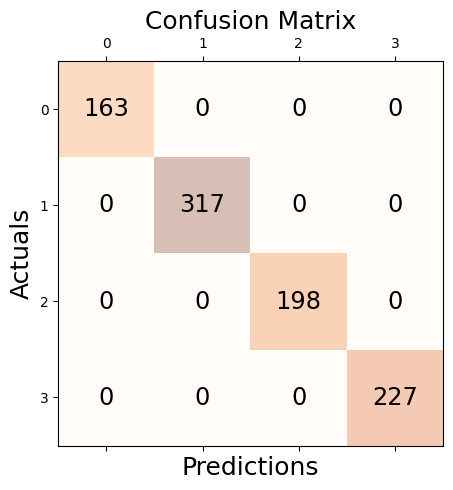

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0


In [33]:
rfc = RandomForestClassifier(n_estimators=400).fit(X_train_scaled, y_train)
y_pred_rfc = rfc.predict(X_test_scaled)
evaluate_model(y_test, y_pred_rfc)

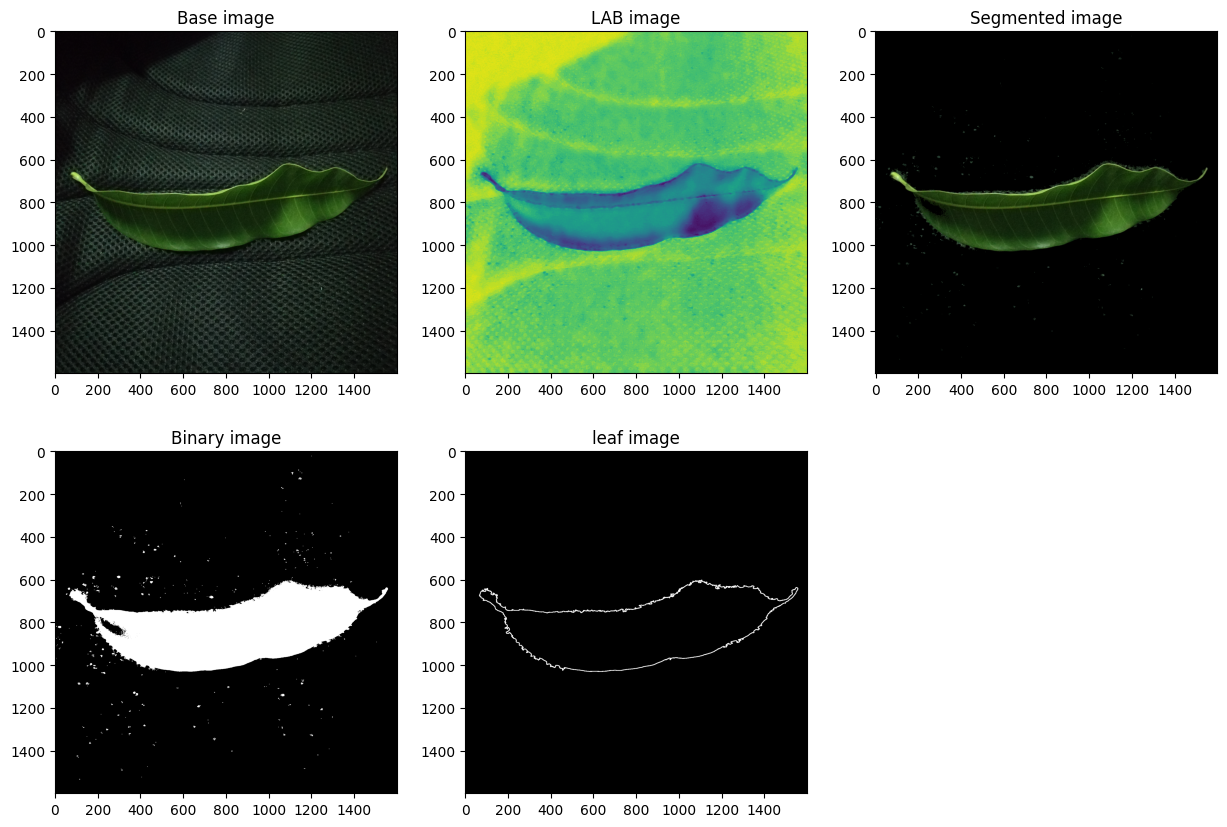

,area,perimeter,physiological_length,physiological_width,aspect_ratio,rectangularity,circularity,diameter,correlation,inverse_difference_moments,entropy
0,335879.0,4506.408615,1493,431,0.288681,0.52197,0.207841,653.952923,0.806676,0.880319,2.158336


In [54]:
names = ['area','perimeter','physiological_length','physiological_width','aspect_ratio','rectangularity','circularity',
             'diameter','mean_red','mean_green','mean_blue','stddev_red','stddev_green','stddev_blue',
             'contrast','correlation','inverse_difference_moments','entropy'
        ]

features = extract_features("./../Downloads/Test-leaves/IMG_20231212_183707.jpg")

test = pd.DataFrame([features], columns=names)
test = test.drop(["stddev_blue", "stddev_green", "stddev_red", "mean_red", "mean_green", "mean_blue", "contrast"] ,axis=1)


test_scaled = scaler.transform(test)
test.head()

In [55]:
models = {'SVM': svc, 'RF': rfc, 'KNN': neigh}
test_prediction(models, test_scaled)


SVM Predictions:
Sample 1: Predicted: Mango

RF Predictions:
Sample 1: Predicted: Mango

KNN Predictions:
Sample 1: Predicted: Mango
